# Classifying Fake News
Your goal is to use this data set to make an algorithm able to determine if an article is fake news or not. We provide you with 2 files, one with news labeled as fake, and another with news labeles as containing true information. You have four columns on each file title/text/subject/date.  

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import matplotlib.pyplot as plt
import contractions
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import keras
import tensorflow as tf
from gensim.models import word2vec

In [2]:
#Obtaining True news dataframe
true_news = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectFN/data/true.csv")
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
#Obtaining Fake news dataframe
fake_news = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectFN/data/fake.csv")
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
#Applying the appropriate labels to True and Fake news instances
true_news["label"] = [1 for i in true_news.index]
fake_news["label"] = [0 for i in fake_news.index]
true_news.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [5]:
fake_news.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [6]:
#Combining True and Fake news dataframes together and creating the wordcount feature
full_dataset = pd.concat([true_news, fake_news], ignore_index=True)
full_dataset["wordcount"] = full_dataset["text"].str.split().str.len()
full_dataset.sample(10)

,title,text,subject,date,label,wordcount
22438,"In NC, It’s Not Rape If Person Revokes Consen...",A Fayetteville woman has just learned that und...,News,"June 25, 2017",0,481
31060,MOST DIVISIVE POTUS EVER Takes Swipe At Trump ...,Barack Obama stutters through yet another jerk...,politics,"Oct 20, 2017",0,557
32621,CHER HUMILIATES Democrats Over Childish Neil G...,"DEMS,The Merrick Garland SHIP HAS SAILED Let ...",politics,"Apr 4, 2017",0,126
39214,CA FIRE UPDATE: Jesus Fabian Gonzalez Arrested...,"Yesterday, a man who is likely an illegal alie...",left-news,"Oct 18, 2017",0,878
22432,"Supreme Court Smacks Down Religious Nuts, Mak...",Ever since same-sex marriage became the law of...,News,"June 26, 2017",0,335
6291,Trump pick for NSC post Crowley to step down: ...,"WASHINGTON (Reuters) - Monica Crowley, the for...",politicsNews,"January 16, 2017",1,200
15243,War crimes court backs Burundi investigation,AMSTERDAM (Reuters) - The International Crimin...,worldnews,"November 9, 2017",1,276
35038,CROWD OF GERMAN PATRIOTS Greets Merkel Shoutin...,Merkel was booed by residents of Saxony who re...,politics,"Jun 27, 2016",0,19
21784,Ohio Fireman In Deep Sh*t For HORRIBLE Remark...,A firefighter in Ohio recently came under fire...,News,"September 16, 2017",0,258
2881,U.S. appeals court denies Hawaii bid to narrow...,SAN FRANCISCO (Reuters) - A U.S. appeals court...,politicsNews,"July 7, 2017",1,392


In [7]:
#Automatically generating an EDA report using pandas_profiling, containing information about feature and label distribution as well as correlation information
profile_EDA = pp.ProfileReport(full_dataset)
profile_EDA

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


In [8]:
#Dropping instances with no words in the main body of the text
print(full_dataset.shape)
full_dataset = full_dataset.drop(full_dataset.index[full_dataset["wordcount"] == 0])
print(full_dataset.shape)

(44898, 6)
(44267, 6)


In [9]:
#Combining the three fields containing text information into one large string format field for NLP operations
combined_fields = full_dataset[["subject", "title", "text"]].astype(str).agg(" ".join, axis=1)
combined_fields.iloc[0]

'politicsNews As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional incr

In [10]:
#Expanding contractions, removing stop words, stemming words, and removing punctuation to clean text for word vectorization
stopwords_english = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.PorterStemmer()
cleaned = combined_fields.str.replace("-", " ", regex=False).apply(lambda x: " ".join([stemmer.stem(w, to_lowercase=False) for w in nltk.word_tokenize(contractions.fix(x, slang=False)) if w not in stopwords_english])).str.replace('[^A-Za-z0-9\s]+', '', regex=True)
cleaned.iloc[0]

'politicsNew As US budget fight loom  Republican flip fiscal script WASHINGTON  Reuter  The head conserv Republican faction US Congress  vote month huge expans nation debt pay tax cut  call  fiscal conserv  Sunday urg budget restraint 2018  In keep sharp pivot way among Republican  US Repres Mark Meadow  speak CBS   Face Nation   drew hard line feder spend  lawmak brace battl Januari  When return holiday Wednesday  lawmak begin tri pass feder budget fight like link issu  immigr polici  even Novemb congression elect campaign approach Republican seek keep control Congress  Presid Donald Trump Republican want big budget increas militari spend  Democrat also want proport increas non defens  discretionari  spend program support educ  scientif research  infrastructur  public health environment protect   The  Trump  administr alreadi will say   We go increas non defens discretionari spend  7 percent    Meadow  chairman small influenti Hous Freedom Caucu  said program   Now  Democrat say enoug

In [11]:
#Splitting the data into training and test sets using an 80/20 split; larger training set enables further splitting for validation set creation or cross-validation purposes
news_X_train, news_X_test, y_train, y_test = train_test_split(cleaned, full_dataset["label"], test_size=0.2, random_state=42)
print(news_X_train.shape)
print(y_train.shape)
print(news_X_test.shape)
print(y_test.shape)

(35413,)
(35413,)
(8854,)
(8854,)


In [12]:
#Using Term Frequency-Inverse Document Frequency vectorization to facilitate classifying the text using Multinomial Naive Bayes classifier
tfidf = TfidfVectorizer(strip_accents="unicode", stop_words="english")
tfidf.fit(cleaned)
tfidf_X_train, tfidf_X_test = tfidf.transform(news_X_train), tfidf.transform(news_X_test)
print(tfidf_X_train.shape)
print(tfidf_X_test.shape)

(35413, 174425)
(8854, 174425)


In [13]:
#Training Multinomial Naive Bayes classifier using training set data and scoring its accuracy on training and test sets to determine degree of overfitting
newsbasicNB = MultinomialNB()
newsbasicNB.fit(tfidf_X_train, y_train)
print("Training accuracy:", newsbasicNB.score(tfidf_X_train, y_train))
print("Test set accuracy:", newsbasicNB.score(tfidf_X_test, y_test))

Training accuracy: 0.949961878406235
Test set accuracy: 0.9412694827196747


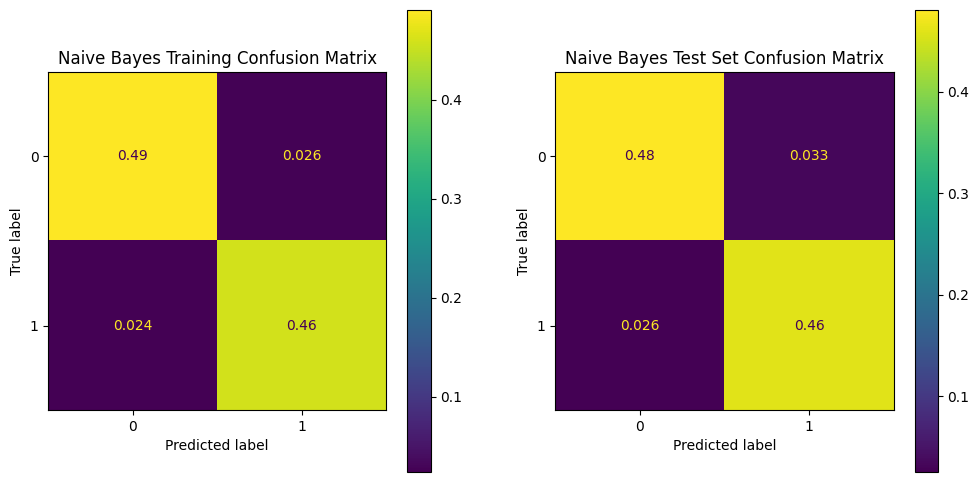

In [14]:
#Generating confusion matrices for training and test set predictions
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ConfusionMatrixDisplay.from_estimator(newsbasicNB, tfidf_X_train, y_train, normalize="all", ax=axs[0])
ConfusionMatrixDisplay.from_estimator(newsbasicNB, tfidf_X_test, y_test, normalize="all", ax=axs[1])
axs[0].set_title("Naive Bayes Training Confusion Matrix")
axs[1].set_title("Naive Bayes Test Set Confusion Matrix")
plt.show()

In [15]:
#Generating classification reports for training and test set predictions
print("Multinomial Naive Bayes Training Classification Report:")
print(classification_report(y_train, newsbasicNB.predict(tfidf_X_train)))
print("Multinomial Naive Bayes Test Set Classification Report:")
print(classification_report(y_test, newsbasicNB.predict(tfidf_X_test)))

Multinomial Naive Bayes Training Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     18303
           1       0.95      0.95      0.95     17110

    accuracy                           0.95     35413
   macro avg       0.95      0.95      0.95     35413
weighted avg       0.95      0.95      0.95     35413

Multinomial Naive Bayes Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      4548
           1       0.93      0.95      0.94      4306

    accuracy                           0.94      8854
   macro avg       0.94      0.94      0.94      8854
weighted avg       0.94      0.94      0.94      8854



In [16]:
#Using 8-fold Cross-Validated Hyperparameter Grid Search to tune Multinomial Naive Bayes classifier, determining optimal set of hyperparameters
gridtuner = GridSearchCV(MultinomialNB(), param_grid={"alpha": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                                                      "fit_prior": [True, False],
                                                      "class_prior": [[0, 1], [.1, .9], [.2, .8], [.3, .7], [.4, .6], [.5, .5], [.6, .4], [.7, .3], [.8, .2], [.9, .1], [1, 0], None]},
                                                      cv=8, n_jobs=-1)
gridtuner.fit(tfidf_X_train, y_train)
print(gridtuner.best_params_)

{'alpha': 0, 'class_prior': [0.2, 0.8], 'fit_prior': True}


C:\Users\yhasw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


In [17]:
#Training classifier using optimal hyperparameters found during grid search and comparing training and test set prediction accuracy to identify signs of overfitting
newstunedNB = gridtuner.best_estimator_
newstunedNB.fit(tfidf_X_train, y_train)
print("Tuned Training Accuracy:", newstunedNB.score(tfidf_X_train, y_train))
print("Tuned Test Set Accuracy:", newstunedNB.score(tfidf_X_test, y_test))

Tuned Training Accuracy: 0.998079801202948
Tuned Test Set Accuracy: 0.9723288908967698


C:\Users\yhasw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


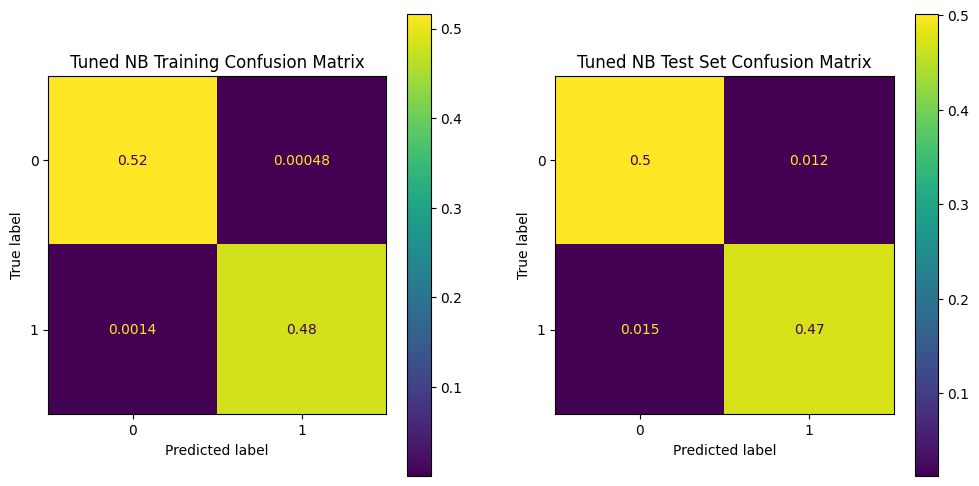

In [18]:
#Generating confusion matrices for training and test set predictions of tuned Multinomial Naive Bayes classifier
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ConfusionMatrixDisplay.from_estimator(newstunedNB, tfidf_X_train, y_train, normalize="all", ax=axs[0])
ConfusionMatrixDisplay.from_estimator(newstunedNB, tfidf_X_test, y_test, normalize="all", ax=axs[1])
axs[0].set_title("Tuned NB Training Confusion Matrix")
axs[1].set_title("Tuned NB Test Set Confusion Matrix")
plt.show()

In [19]:
#Generating classification reports for training and test set predictions of tuned Multinomial Naive Bayes classifier
print("Tuned NB Training Classification Report:")
print(classification_report(y_train, newstunedNB.predict(tfidf_X_train)))
print("Tuned NB Test Set Classification Report:")
print(classification_report(y_test, newstunedNB.predict(tfidf_X_test)))

Tuned NB Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18303
           1       1.00      1.00      1.00     17110

    accuracy                           1.00     35413
   macro avg       1.00      1.00      1.00     35413
weighted avg       1.00      1.00      1.00     35413

Tuned NB Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      4548
           1       0.97      0.97      0.97      4306

    accuracy                           0.97      8854
   macro avg       0.97      0.97      0.97      8854
weighted avg       0.97      0.97      0.97      8854



In [20]:
#Word tokenizing article text for use with Word2Vec model
tokenized_X_train = pd.Series([nltk.word_tokenize(doc) for doc in news_X_train], name="tokenized")
tokenized_X_test = pd.Series([nltk.word_tokenize(doc) for doc in news_X_test], name="tokenized")
wordlengths = tokenized_X_train.str.len()
wordlengths.describe()

count    35413.000000
mean       265.292830
std        220.378091
min          7.000000
25%        146.000000
50%        235.000000
75%        326.000000
max       5203.000000
Name: tokenized, dtype: float64

In [21]:
#Constructing Word2Vec model, saving relevant parameters for sequence padding/truncating and LSTM model construction, removing out-of-vocabulary words from test data unseen by trained Word2Vec model
w2v_model = word2vec.Word2Vec(tokenized_X_train, vector_size = 300, window = 20, min_count = 1, sg = 1)

vocab_size = len(w2v_model.wv)
max_seq_len = int(wordlengths.describe().iloc[-2])

vocab = w2v_model.wv.key_to_index.keys()
embedding_matrix = w2v_model.wv[vocab]
vocab_set = set(vocab)

def remove_OOV(sample, vocab_set):
    """Removes words from tokenized text that are 
    not found in the training set vocabulary."""
    return [w for w in sample if w in vocab_set]

tokenized_X_test = tokenized_X_test.apply(lambda x: remove_OOV(x, vocab_set=vocab_set))
tokenized_X_test

0       [worldnew, Ukrain, s, controversi, law, reform...
1       [worldnew, Tanzania, presid, name, tax, expert...
2       [politicsNew, Can, complac, potenti, threat, N...
3       [worldnew, Turkey, deni, ludicr, report, plan,...
4       [worldnew, Germani, s, conserv, SPD, start, ta...
                              ...                        
8849    [worldnew, US, North, Korea, clash, UN, forum,...
8850    [New, WATCH, Dem, Rep, Just, Call, Out, Trump,...
8851    [New, Trump, Is, HOPING, Peopl, Will, See, Thi...
8852    [worldnew, US, offici, label, treatment, Rohin...
8853    [worldnew, US, back, forc, plan, enter, Deir, ...
Name: tokenized, Length: 8854, dtype: object

In [22]:
#Replacing word tokens in tokenized datasets with token indices generated by Word2Vec model
def w2v_sequence_indexer(w2v_model, tokenized_text):
    token_indices = []
    for token in tokenized_text:
        try:
            token_indices.append(int(w2v_model.wv.key_to_index[token]))
        except KeyError:
            continue
    return token_indices

indexed_X_train = tokenized_X_train.apply(lambda x: w2v_sequence_indexer(w2v_model, x))
indexed_X_test = tokenized_X_test.apply(lambda x: w2v_sequence_indexer(w2v_model, x))
indexed_X_train

0        [122, 0, 28, 16, 19, 303, 13, 1419, 1802, 1682...
1        [11, 27706, 1851, 98, 109425, 0, 12890, 36031,...
2        [144, 3141, 358, 3115, 743, 95, 819, 2761, 595...
3        [30, 4065, 1510, 9621, 10922, 22910, 58, 206, ...
4        [11, 1290, 2829, 17976, 1646, 8995, 866, 1265,...
                               ...                        
35408    [122, 11, 204, 190, 1433, 2639, 3134, 626, 0, ...
35409    [144, 448, 1197, 8, 257, 3014, 1222, 692, 532,...
35410    [802, 11, 2116, 16631, 38323, 8412, 1965, 5328...
35411    [122, 7, 89, 85, 5, 116, 529, 648, 4, 1345, 29...
35412    [144, 4, 1520, 421, 1220, 359, 2091, 247, 2147...
Name: tokenized, Length: 35413, dtype: object

In [23]:
indexed_X_test

0       [144, 1347, 358, 891, 59, 510, 251, 2940, 445,...
1       [144, 9842, 37, 235, 89, 825, 1082, 625, 728, ...
2       [122, 1968, 11202, 590, 380, 103, 726, 545, 13...
3       [144, 616, 400, 8856, 25, 85, 1791, 3648, 4, 7...
4       [144, 654, 358, 198, 2453, 230, 100, 285, 1008...
                              ...                        
8849    [144, 4, 103, 172, 2040, 421, 3222, 255, 503, ...
8850    [11, 1276, 3248, 1159, 800, 1978, 2073, 0, 104...
8851    [11, 0, 629, 79239, 956, 1341, 3192, 69, 797, ...
8852    [144, 4, 45, 2292, 1597, 1031, 1501, 3372, 294...
8853    [144, 4, 55, 115, 85, 735, 3543, 562, 3640, 19...
Name: tokenized, Length: 8854, dtype: object

In [24]:
#Padding or truncating tokenized articles to a sequence length of 326, matching the value of the 3rd quartile for the word count of the tokenized articles
padded_X_train = keras.utils.pad_sequences(indexed_X_train, padding = 'post', maxlen=max_seq_len, truncating='post')
padded_X_test = keras.utils.pad_sequences(indexed_X_test, padding = 'post', maxlen=max_seq_len, truncating='post')
padded_X_train.shape

(35413, 326)

In [25]:
padded_X_test.shape

(8854, 326)

In [26]:
#Construction of LSTM-RNN classifier. Specification of conditions for ending training early and saving the model with the lowest validation error
model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix], input_length=max_seq_len))
model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.LSTM(max_seq_len, return_sequences=True))
model.add(keras.layers.LSTM(18))
model.add(keras.layers.Dense(1, activation='sigmoid'))

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=3,
                                  verbose=1,
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath='models/lstm_with_w2v.h5',
                                    verbose=1,
                                    save_best_only=True)
]

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 326, 300)          52694700  
                                                                 
 dropout (Dropout)           (None, 326, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 326, 326)          817608    
                                                                 
 lstm_1 (LSTM)               (None, 18)                24840     
                                                                 
 dense (Dense)               (None, 1)                 19        
                                                                 
Total params: 53,537,167
Trainable params: 53,537,167
Non-trainable params: 0
_________________________________________________________________


In [27]:
#Compiling and training LSTM-RNN classifier with added conditions and using 60/20/20 split for training/validation/test sets
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

tf.config.run_functions_eagerly(True)

history = model.fit(padded_X_train, y_train, validation_split=0.25, callbacks=callbacks, epochs=100)

Epoch 1/100


C:\Users\yhasw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


830/830 [==============================] - ETA: 0s - loss: 0.6772 - accuracy: 0.5760
Epoch 1: val_loss improved from inf to 0.64762, saving model to models\lstm_with_w2v.h5
830/830 [==============================] - 2352s 3s/step - loss: 0.6772 - accuracy: 0.5760 - val_loss: 0.6476 - val_accuracy: 0.6011
Epoch 2/100
830/830 [==============================] - ETA: 0s - loss: 0.6124 - accuracy: 0.6264
Epoch 2: val_loss improved from 0.64762 to 0.25962, saving model to models\lstm_with_w2v.h5
830/830 [==============================] - 2315s 3s/step - loss: 0.6124 - accuracy: 0.6264 - val_loss: 0.2596 - val_accuracy: 0.9338
Epoch 3/100
830/830 [==============================] - ETA: 0s - loss: 0.5374 - accuracy: 0.6803
Epoch 3: val_loss did not improve from 0.25962
830/830 [==============================] - 2313s 3s/step - loss: 0.5374 - accuracy: 0.6803 - val_loss: 0.6929 - val_accuracy: 0.5184
Epoch 4/100
830/830 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.539

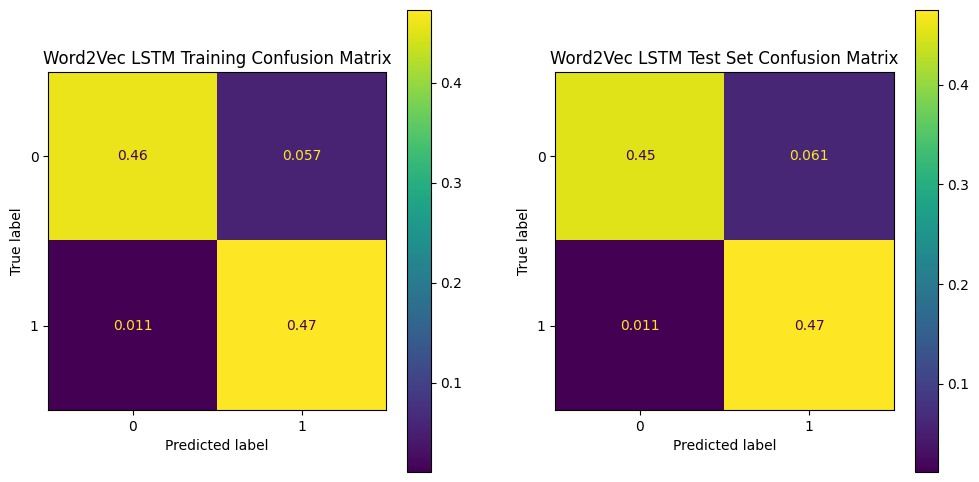

In [28]:
#Generating predictions on training and test sets using the saved best model, and plotting confusion matrices of predicted vs true labels
bestmodel = keras.models.load_model('models/lstm_with_w2v.h5')
predtrain = np.where(bestmodel.predict(padded_X_train, verbose=0) > 0.5, 1, 0)
predtest = np.where(bestmodel.predict(padded_X_test, verbose=0) > 0.5, 1, 0)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ConfusionMatrixDisplay.from_predictions(y_train, predtrain, normalize="all", ax=axs[0])
ConfusionMatrixDisplay.from_predictions(y_test, predtest, normalize="all", ax=axs[1])
axs[0].set_title("Word2Vec LSTM Training Confusion Matrix")
axs[1].set_title("Word2Vec LSTM Test Set Confusion Matrix")
plt.show()

In [29]:
#Generating classification reports for the LSTM model predictions on the training and test sets
print("Word2Vec LSTM Training Classification Report:")
print(classification_report(y_train, predtrain))
print("Word2Vec LSTM Test Set Classification Report:")
print(classification_report(y_test, predtest))

Word2Vec LSTM Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     18303
           1       0.89      0.98      0.93     17110

    accuracy                           0.93     35413
   macro avg       0.93      0.93      0.93     35413
weighted avg       0.94      0.93      0.93     35413

Word2Vec LSTM Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      4548
           1       0.89      0.98      0.93      4306

    accuracy                           0.93      8854
   macro avg       0.93      0.93      0.93      8854
weighted avg       0.93      0.93      0.93      8854

